In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import copy

from plotting import plot_utils, load_fits, pycortex_plot_utils, summary_plots, plot_prf_params
from utils import roi_utils
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)


In [2]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
n_subjects = len(subjects)

feature_type_list_long = ['clip_RN50_best_layer_pca']
feature_type_list = ['clip']
n_models = len(feature_type_list)

which_axes_negate = [1,2]
discrim_names, signed_names, n_levels = load_feature_stats.load_discrim_names(which_axes_negate)

which_partial_axes_negate = [1]
axes_to_do_partial = [0,2,3]
partial_discrim_names, partial_signed_names, _ = \
                load_feature_stats.load_partial_discrim_names(axes_to_do_partial, \
                                                              which_partial_axes_negate)
n_total_discrim_types = len(discrim_names)
n_partial_discrim_types = len(partial_discrim_names)

# diff subjects will have diff numbers of voxels
max_voxels = 30000

sem_corr = np.zeros((n_models, n_total_discrim_types, n_subjects, max_voxels))
sem_discrim = np.zeros((n_models, n_total_discrim_types, n_subjects, max_voxels))
sem_means = np.zeros((n_models, n_total_discrim_types, 3, n_subjects, max_voxels))

partial_corrs = np.zeros((n_models, n_partial_discrim_types, n_subjects, max_voxels))

n_voxels_each_subj = np.zeros((n_subjects,),dtype=int)

clip_r2 = np.zeros((n_subjects,max_voxels))

outlist = []

min_samp=5;

for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(feature_type_list_long):

        out= load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False);
        outlist.append(out)
        assert(np.all([(d1==d2) for d1,d2 in zip(out['discrim_type_list'], discrim_names)]))
        assert(np.all(out['axes_to_do']==axes_to_do_partial))
        
        if fi==0:
            n_voxels = int(np.sum(out['voxel_mask']))
            n_samp = out['n_sem_samp_each_axis'] # this is same for all semantic axes.
            n_voxels_each_subj[si] = n_voxels

        c = copy.deepcopy(out['sem_corr_each_axis'].T)
        d = copy.deepcopy(out['sem_discrim_each_axis'].T)
        m = np.moveaxis(copy.deepcopy(out['mean_each_sem_level']),[0,1,2],[2,0,1])

        c[which_axes_negate,:] *= (-1)
        d[which_axes_negate,:] *= (-1)
        
        # take out any pRFs/semantic axes where there were fewer than 10 val set trials
        # that had defined labels, because t-stats won't be very stable.
        # should only happen for the most low-level discrims (i.e. cat vs dog)
        for aa in range(n_total_discrim_types):

            exclude_vox = np.any(n_samp[:,aa,0:n_levels[aa]]<min_samp, axis=1)

            if aa>=5:
                c[aa,exclude_vox] = np.nan
                d[aa,exclude_vox] = np.nan
                m[aa,:,exclude_vox] = np.nan
            else:
                assert(np.sum(exclude_vox)==0)

        sem_corr[fi,:,si,0:n_voxels] = c
        sem_discrim[fi,:,si,0:n_voxels] = d
        sem_means[fi,:,:,si,0:n_voxels] = m

        c_partial = copy.deepcopy(out['sem_partial_corrs']).T
        c_partial[which_partial_axes_negate,:] *= (-1)
        assert(np.all(out['sem_partial_n_samp']>=min_samp))
        partial_corrs[fi,:,si,0:n_voxels] = c_partial;

        # going to use the fit performance of clip model on each voxel, as a threshold for
        # whether to include it. this is very lenient.
        clip_r2[si,0:n_voxels] = out['val_r2'][:,0]
            
out = outlist

In [20]:
# make some groups (averaging over all superord or basic level discrims)
# will help smooth out the noise for these low-n discriminations

inds2group = [[0], [1], [2], [3], [4], np.arange(5,17), np.arange(28,44), \
              np.arange(17,28), np.arange(44,56)]
group_names = [discrim_names[ii] for ii in [0,1,2,3,4]] + \
                ['things-superord','stuff-superord' ,'things-basic', 'stuff-basic']

sem_discrim_grouped = np.zeros((n_models, len(group_names), n_subjects, max_voxels))
sem_corr_grouped = np.zeros((n_models, len(group_names), n_subjects, max_voxels))

for gg, inds in enumerate(inds2group):
    # here we need a nanmean, because some of these values can be nan, when there were not
    # enough trials for at least one of the categories. Consider only the not-nan ones here.
    sem_discrim_grouped[:,gg,:,:] = np.nanmean(np.abs(sem_discrim[:,inds,:,:]), axis=1)
    sem_corr_grouped[:,gg,:,:] = np.nanmean(np.abs(sem_corr[:,inds,:,:]), axis=1)
    print(group_names[gg])
    print(np.array(discrim_names)[inds])

indoor_outdoor
['indoor_outdoor']
natural_humanmade
['natural_humanmade']
animacy
['animacy']
real_world_size_binary
['real_world_size_binary']
real_world_size_continuous
['real_world_size_continuous']
things-superord
['accessory' 'animal' 'appliance' 'electronic' 'food' 'furniture' 'indoor'
 'kitchen' 'outdoor' 'person' 'sports' 'vehicle']
stuff-superord
['building' 'ceiling' 'floor' 'food-stuff' 'furniture-stuff' 'ground'
 'other' 'plant' 'raw-material' 'sky' 'solid' 'structural' 'textile'
 'wall' 'water' 'window']
things-basic
['within_accessory' 'within_animal' 'within_appliance' 'within_electronic'
 'within_food' 'within_furniture' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle']
stuff-basic
['within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_ground' 'within_plant'
 'within_raw-material' 'within_solid' 'within_structural' 'within_textile'
 'within_wall' 'within_water']


In [5]:
sem_discrim.shape

(1, 56, 8, 30000)

In [3]:
# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [26]:
import cortex
from utils import numpy_utils

mm=0;

port=44442

title = 'CLIP semantic discriminability, %s'%(summary_plots.get_substr(out));

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

for si, ss in enumerate(subjects):
    
    names += ['S%d: CLIP fit performance (sqrt R2)'%ss]
    maps += [np.sqrt(out[si]['val_r2'][:,0])]
    cmaps += ['PuBu']
    mins += [0]
    maxes += [0.60]
    
   
    # partial corr coefs for main highlevel axes
    dd2plot = [0,1,2]
    for di, dd in enumerate(dd2plot):

        cvals = copy.deepcopy(partial_corrs[mm,dd,si,0:n_voxels_each_subj[si]])
        maps += [cvals]
        names += ['S%d: %s (partial corr)'%(ss,partial_signed_names[dd])]
        mins += [-1]
        maxes += [1]
        cmaps += ['RdBu']
        
    # raw corr coefs for main highlevel axes
    dd2plot = [0,2,3]
    for di, dd in enumerate(dd2plot):

        cvals = copy.deepcopy(sem_corr[mm,dd,si,0:n_voxels_each_subj[si]])
        maps += [cvals]
        names += ['S%d: %s (corr coef)'%(ss,signed_names[dd])]
        mins += [-1]
        maxes += [1]
        cmaps += ['RdBu']
        
    # t-stats for main highlevel axes
    dd2plot = [0,2,3]
    for di, dd in enumerate(dd2plot):

        tvals = copy.deepcopy(sem_discrim[mm,dd,si,0:n_voxels_each_subj[si]])
        maps += [tvals]
        names += ['S%d: %s (t-stat)'%(ss,signed_names[dd])]
        mins += [-30]
        maxes += [30]
        cmaps += ['RdBu']

    dd=4;
    corrvals = copy.deepcopy(sem_corr[mm,dd,si,0:n_voxels_each_subj[si]])
    maps += [corrvals]
    names += ['S%d: corr with 3-level real-world size'%(ss)]
    mins += [-1]
    maxes += [1]
    cmaps += ['RdBu']
    
    dd2plot = [5,6,7,8]
    for di, dd in enumerate(dd2plot):

        tvals = copy.deepcopy(sem_discrim_grouped[mm,dd,si,0:n_voxels_each_subj[si]])
        maps += [tvals]
        names += ['S%d: %s (mean abs t)'%(ss,group_names[dd])]
        mins += [0]
        if dd<7:
            maxes += [20]
        else:
            maxes += [10]
        cmaps += ['PuBu']
        
    r2_thresh = 0.01
    vox2plot.append(clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh)
    
    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]
    
# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]



voxel_mask = [o['voxel_mask'] for o in out]
nii_shape = [o['brain_nii_shape'] for o in out]
volume_space = out[0]['volume_space']

viewer = pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=roi_def, simplest_roi_maps=True, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442


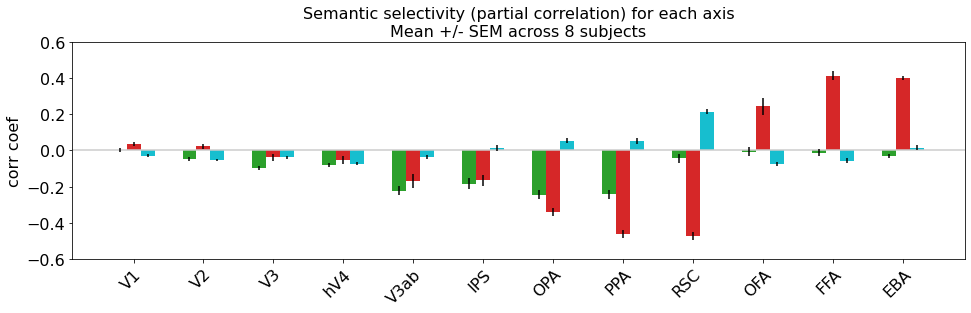

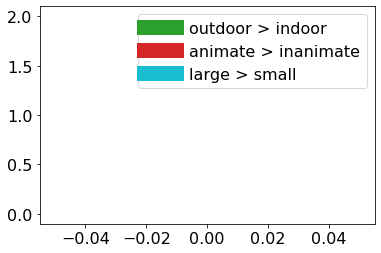

In [18]:
# plot signed partial corr coef, each axis
mm=0;

r2_thresh = 0.01
# r2_thresh = -10

# colors = cm.tab10(np.linspace(0,1,4))[[0,1,3],:]
colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
    vals = copy.deepcopy(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]])

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Semantic selectivity (partial correlation) for each axis\nMean +/- SEM across 8 subjects'
# title = '%s, partial corr (signed) with each axis (avg +/- SEM over subjects)'%\
#             (feature_type_list[fi])
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.20, \
            xticklabels=roi_names, ylabel='corr coef', \
            ylim=[-0.6, 0.6], title=title, horizontal_line_pos=0,\
            legend_labels=partial_signed_names, \
            legend_overlaid=False, legend_separate=True, \
            fig_size=(16,4))

fn2save = '/user_data/mmhender/imStat/figures/Semantic_selectivity_signed_ROIavg.pdf'
plt.savefig(fn2save)

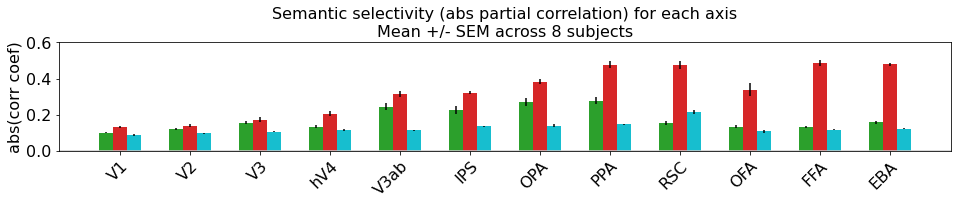

In [19]:
# plot abs partial corr coef, each axis
mm=0;

r2_thresh = 0.01
# r2_thresh = -10
colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

# colors = cm.tab10(np.linspace(0,1,4))[[0,1,3],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
    vals = copy.deepcopy(np.abs(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]]))

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
legend_separate = True
# title = '%s, partial corr (abs) with each axis (avg +/- SEM over subjects)'%\
#             (feature_type_list[fi])
title='Semantic selectivity (abs partial correlation) for each axis\nMean +/- SEM across 8 subjects'
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.20, \
            xticklabels=roi_names, ylabel='abs(corr coef)', \
            ylim=[0, 0.6], title=title, horizontal_line_pos=0,\
            legend_labels=partial_signed_names, \
            legend_overlaid=False, legend_separate=False, \
            fig_size=(16,2))

fn2save = '/user_data/mmhender/imStat/figures/Semantic_selectivity_abs_ROIavg.pdf'
plt.savefig(fn2save)

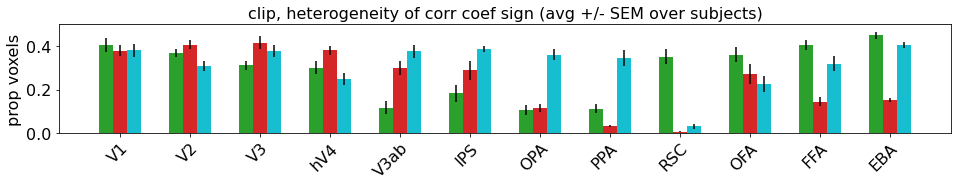

In [22]:
# plot heteregeneity of signs

mm=0;

r2_thresh = 0.01

# colors = cm.tab10(np.linspace(0,1,4))[[0,1,3],:]
colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
    vals = copy.deepcopy(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]])

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)

        for di in range(3):
            
            prop_neg = np.mean(vals[di,inds_this_roi]<0)
            prop_pos = np.mean(vals[di,inds_this_roi]>0)
            
            roi_mean_vals[ri,di,si] = np.min([prop_neg, prop_pos])
            
mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
title = '%s, heterogeneity of corr coef sign (avg +/- SEM over subjects)'%\
            (feature_type_list[fi])

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.20, \
            xticklabels=roi_names, ylabel='prop voxels', \
            ylim=[-0, 0.5], title=title, horizontal_line_pos=0.5,\
            legend_labels=partial_signed_names, \
            legend_overlaid=False, legend_separate=False, \
            fig_size=(16,2))

fn2save = '/user_data/mmhender/imStat/figures/Semantic_selectivity_heterogeneity.pdf'
plt.savefig(fn2save)

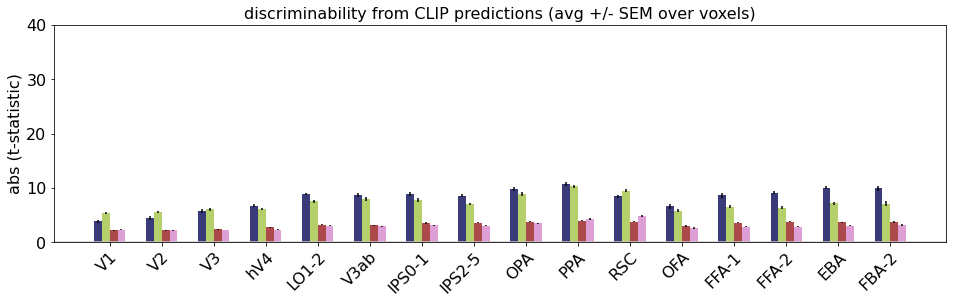

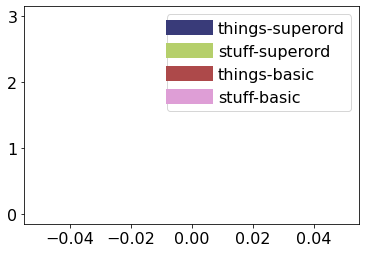

Stopping server


In [17]:
# plot discriminability for all the different levels of categorization
mm=0;

r2_thresh = 0.01;

dd2plot = np.array([5,6,7,8])
discrim_type_colors = cm.tab20b(np.linspace(0,1,len(dd2plot)))
   
roi_mean_vals = np.zeros((n_rois, len(dd2plot), n_subjects))

for si in range(n_subjects):

    vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
    
    vals = np.abs(sem_discrim_grouped[mm,dd2plot,si,0:n_voxels_each_subj[si]])
        
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

        # need a nanmean here, because there might be some voxels in an ROI where
        # there were not enough trials to evaluate any of the discriminations 
        # (it is based on where/how large these voxels' pRFs were)
        roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
legend_separate=True
title = 'discriminability from CLIP predictions (avg +/- SEM over voxels)'

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=discrim_type_colors, space=0.20, \
                xticklabels=roi_names, ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(group_names)[dd2plot], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


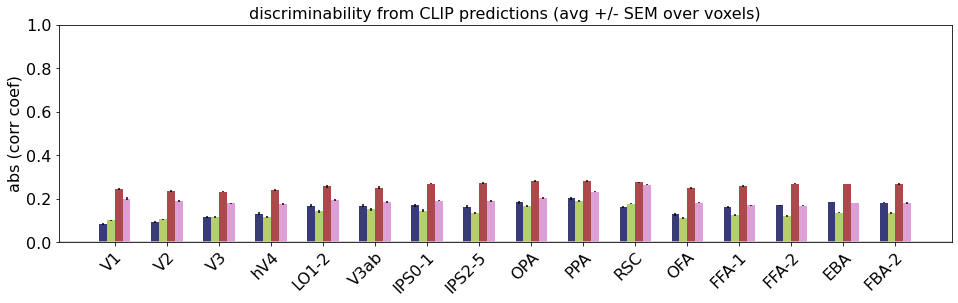

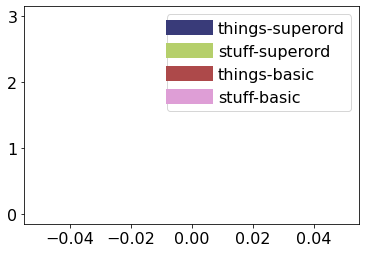

In [16]:
# plot discriminability for all the different levels of categorization
mm=0;

r2_thresh = 0.01;

dd2plot = np.array([5,6,7,8])
discrim_type_colors = cm.tab20b(np.linspace(0,1,len(dd2plot)))
   
roi_mean_vals = np.zeros((n_rois, len(dd2plot), n_subjects))

for si in range(n_subjects):

    vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
    
    vals = np.abs(sem_corr_grouped[mm,dd2plot,si,0:n_voxels_each_subj[si]])
        
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

        # need a nanmean here, because there might be some voxels in an ROI where
        # there were not enough trials to evaluate any of the discriminations 
        # (it is based on where/how large these voxels' pRFs were)
        roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
legend_separate=True
title = 'discriminability from CLIP predictions (avg +/- SEM over voxels)'

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=discrim_type_colors, space=0.20, \
                xticklabels=roi_names, ylabel='abs (corr coef)', \
                ylim=[0, 1], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(group_names)[dd2plot], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


In [15]:
## More code for pycortex plots in case needed later

port=44442

vox2plot = clip_r2>0.01

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 for CLIP best layer fit']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(clip_r2)]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [9, 360, 10, 0.8]

dd2plot = np.where([not 'within' in name for name in discrim_names])[0]

for dd in dd2plot:
    
    name = discrim_names[dd]
    names += ['%s discriminability (t-statistic)'%(name)]
    tvals = copy.deepcopy(sem_discrim[0,dd,:])
    maps += [(-1)*tvals]
    mins += [-20]
    maxes += [20]
    cmaps += ['RdBu']
    
    if name in top_two['stuff_top_two'].keys():
        sub_names = top_two['stuff_top_two'][name]
    elif name in top_two['things_top_two'].keys():
        sub_names = top_two['things_top_two'][name]
    else:
        sub_names=[]
        
    if len(sub_names)>0:
        
        within_ind = np.where(['within_%s'%name==dname for dname in discrim_names])[0][0]
        # since we invert the t-statistic - it reflects label 0 being > label 1
        names += ['%s > %s'%(sub_names[0], sub_names[1])]
        within_tvals = copy.deepcopy(sem_discrim[0,within_ind,:]) 
        maps += [(-1)*within_tvals]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']
        
        names += ['%s vs %s (thresh)'%(sub_names[0], sub_names[1])]
        vals_masked = copy.deepcopy(within_tvals)
        vals_masked[tvals>(-5)] = np.nan
        maps += [(-1)*vals_masked]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']

for gi, gname in enumerate(group_names): 
    
    if gi<4:
        continue
    
    names += ['avg abs ' + gname]
    tvals = copy.deepcopy(sem_discrim_grouped[gi,:])
    maps += [tvals]
    mins += [0]
    maxes += [10]
    cmaps += ['PuBu']
    
for pc in range(n_pc2plot): 
  
    names += ['pc %d'%(pc+1)]
    maps += [(scores_in_mask[:,pc] - np.nanmean(scores_in_mask[:,pc]))/np.nanstd(scores_in_mask[:,pc])]
    mins += [-10]
    maxes += [10]
    cmaps += ['RdBu']
        
pycortex_plot_utils.plot_maps_pycortex(subject, title=fitting_type, port=port, maps=maps, names=names, roi_def=roi_def, \
                       mins=mins, maxes=maxes, cmaps=cmaps, vox2plot=vox2plot)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


Data is in 3d volume space
navigate browser to: 127.0.0.1:44442
Started server on port 44442
